In [1]:

import sys

sys.path.insert(0, '/home/george/Projects/Python/bind-af2-embed/src')
sys.path.insert(0, '/Users/tsitsiridis/Projects/bind-af2-embed/src')


# Import dependencies
%load_ext autoreload
%autoreload 2

import pandas as pd
from config import AppConfig
from plots import Plots
from ml.common import Performance
import numpy as np
import math
from scipy.stats import t
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

### Read predictions files

In [2]:
def read_predictions_df(tag: str, cutoff: float = 0.5) -> Performance:
    config = AppConfig()
    predictions_path = config.get_ml_predictions_path()
    predictions_path = predictions_path / tag / 'test_total.csv'
    df = pd.read_csv(str(predictions_path))
    return df

def read_performance_df(tag: str, cutoff: float = 0.5) -> pd.DataFrame:
    config = AppConfig()
    perf_path = config.get_ml_model_path()
    perf_path = perf_path / tag / 'model_test_perf.csv'
    df = pd.read_csv(str(perf_path))
    return df

In [3]:
#tags = ['emb_filtered', 'emb_total', 'emb_binary_filtered', 'cnn_combined_2', 'cnn_combined_3', 'cnn_combined_binary_3']
tags = ['emb_filtered', 'cnn_combined_3']


performance_df = {tag: read_performance_df(tag) for tag in tags}

predictions_df = {tag: read_predictions_df(tag) for tag in tags}

In [7]:
df = predictions_df['emb_filtered']
perf = Performance.df_to_performance(df[df.cutoff == 0.5], is_train=False)

{'mcc': '0.35 ± 0.03 %', 'f1': '0.33 ± 0.03 %', 'rec': '0.293 ± 0.03 %', 'prec': '0.54 ± 0.04 %'}


ValueError: If using all scalar values, you must pass an index

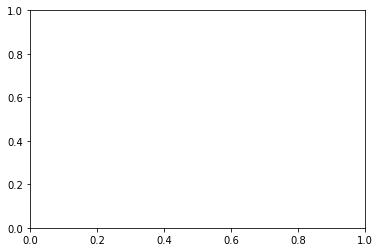

In [16]:
perf.to_dict()
fig, ax = plt.subplots()
Plots.plot_performance_table(perf.to_dict(), ax=ax, class_label='total')
fig.show()

In [ ]:
def get_mean_ci(vec):
    """
    Calculate mean and 95% CI for a given vector
    :param vec: vector
    :return: mean and ci
    """
    mean = round(np.average(vec), 3)
    if len(vec) > 1:
        ci = round(np.std(vec)/math.sqrt(len(vec)) * t.ppf((1 + 0.95) / 2, len(vec)), 3)
    else:
        ci = 0

    return mean, ci

ci_values_per_tag = {}
for tag, df in performance_df.items():
    columns = df.columns[1:-2]
    ci_values = {}
    for column in columns:
        mean, ci = get_mean_ci(df[0:-1][column])
        ci_values[column] = f'{str(mean)} ± %0.2f' % ci
    ci_values_per_tag[tag] = ci_values

df=pd.DataFrame.from_dict(ci_values_per_tag, orient='index')
df.to_csv('stats.csv')
#     mean, ci = get_mean_ci(df[0:-1].f1_total)
#     print(df[0:-1])
#     print(f'{tag}: f1 total = {str(mean)} +- {str(ci)}')               

In [20]:
def get_mean_ci(vec):
    """
    Calculate mean and 95% CI for a given vector
    :param vec: vector
    :return: mean and ci
    """
    mean = round(np.average(vec), 3)
    if len(vec) > 1:
        ci = round(np.std(vec)/math.sqrt(len(vec)) * t.ppf((1 + 0.95) / 2, len(vec)), 3)
    else:
        ci = 0

    return mean, ci

ci_values_per_tag = {}
for tag, df in performance_df.items():
    columns = df.columns[1:-2]
    ci_values = {}
    for column in columns:
        mean, ci = get_mean_ci(df[0:-1][column])
        ci_values[column] = f'{str(mean)} ± %0.2f' % ci
    ci_values_per_tag[tag] = ci_values

df=pd.DataFrame.from_dict(ci_values_per_tag, orient='index')
df.to_csv('stats.csv')
#     mean, ci = get_mean_ci(df[0:-1].f1_total)
#     print(df[0:-1])
#     print(f'{tag}: f1 total = {str(mean)} +- {str(ci)}')               

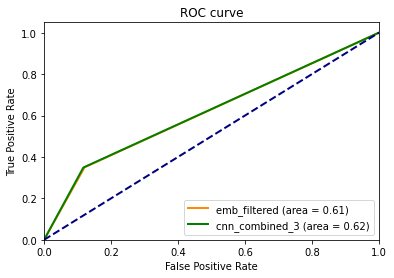

In [21]:
def plot_roc(y_true, y_score, tag: str, ax: plt.axes, col: str):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    ax.plot(
        fpr,
        tpr,
        color=col,
        lw=2,
        label=f"{tag} (area = %0.2f)" % roc_auc,
    )

def get_df(df, ligand=None):
    if ligand is None:
        return df
    return df[df.ligand == ligand]
    
fig, ax = plt.subplots()
colors = ["darkorange","green", "blue"]
def plot_rocs(ligand=None):
    i = 0
    for tag, df in predictions_df.items():
        plot_roc(get_df(df, ligand=ligand)['target'], get_df(df,ligand=ligand)['prediction'], tag, ax,col=colors[i])
        i+=1

    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC curve" )
    ax.legend(loc="lower right")
plot_rocs()
#plot_rocs(ligand='binding')

In [5]:
counts = df[['target', 'prediction']].value_counts()
tp = counts.loc[(1,1)] / sum(counts)
fp = counts.loc[(0,1)] / sum(counts)
tn = counts.loc[(0,0)] / sum(counts)
fn = counts.loc[(1,0)] / sum(counts)

In [6]:
df[df.target == 1]

,tag,protd_id,position,ligand,target,prediction,cutoff,ri,prob,loss
393,test,O25094,33,small,1.0,1,0.5,1.026,0.557,0.000
397,test,O25094,37,small,1.0,1,0.5,0.396,0.522,0.000
450,test,O25094,90,small,1.0,1,0.5,0.180,0.510,0.000
451,test,O25094,91,small,1.0,1,0.5,0.864,0.548,0.000
452,test,O25094,92,small,1.0,0,0.5,0.486,0.473,0.000
...,...,...,...,...,...,...,...,...,...,...
250662,test,Q9HAN9,185,binding,1.0,0,0.5,3.996,0.278,627.031
250691,test,Q9HAN9,214,binding,1.0,0,0.5,8.874,0.007,2245.562
250695,test,Q9HAN9,218,binding,1.0,0,0.5,5.400,0.200,1334.799
250696,test,Q9HAN9,219,binding,1.0,0,0.5,3.600,0.300,862.029


In [45]:
df.loss.mean()

136.207361801911

/tmp/ipykernel_7867/3335055868.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


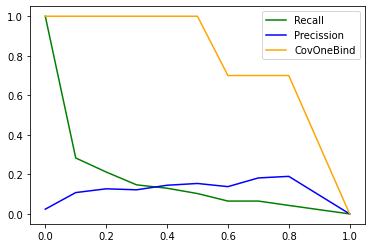

In [64]:
import numpy as np
from ml.common import Performance
import matplotlib.pyplot as plt

cutoffs = df.cutoff.unique()
rec = []
prec = []
covonebind = []
for cutoff in cutoffs:
    performance = Performance.df_to_performance(df[df.cutoff==cutoff])
    rec.append(performance['rec_total'])
    prec.append(performance['prec_total'])
    covonebind.append(performance['covonebind_total'])

fig, ax = plt.subplots()
ax.plot(cutoffs, rec,color='green', label='Recall')
ax.plot(cutoffs, prec,color='blue', label='Precission')
ax.plot(cutoffs, covonebind,color='orange', label = "CovOneBind")
ax.legend()
fig.show()

In [46]:
df1 = df.groupby('protd_id')['prediction', 'target'].sum()
covonebind = len(df1[df1.prediction > 0])/len(df1[df1.target > 0])
print(1e-5)

1e-05


/tmp/ipykernel_7867/2613190845.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1 = df.groupby('protd_id')['prediction', 'target'].sum()


In [42]:
df

,tag,protd_id,position,ligand,target,prediction,cutoff,ri,prob,loss
0,validation_epoch_19,P0AE05,0,metal,0.0,1,0.0,inf,7.150692e-04,0.126600
1,validation_epoch_19,P0AE05,1,metal,0.0,1,0.0,inf,1.505545e-04,0.026670
2,validation_epoch_19,P0AE05,2,metal,0.0,1,0.0,inf,5.079052e-07,0.000000
3,validation_epoch_19,P0AE05,3,metal,0.0,1,0.0,inf,5.576067e-07,0.000169
4,validation_epoch_19,P0AE05,4,metal,0.0,1,0.0,inf,3.618223e-07,0.000000
...,...,...,...,...,...,...,...,...,...,...
72235,validation_epoch_19,D1BQI7,213,binding,0.0,0,0.9,8.965245,3.475481e-03,0.758943
72236,validation_epoch_19,D1BQI7,214,binding,0.0,0,0.9,8.990463,9.536662e-04,0.208005
72237,validation_epoch_19,D1BQI7,215,binding,0.0,0,0.9,8.984796,1.520480e-03,0.331706
72238,validation_epoch_19,D1BQI7,216,binding,0.0,0,0.9,8.881128,1.188718e-02,2.606871


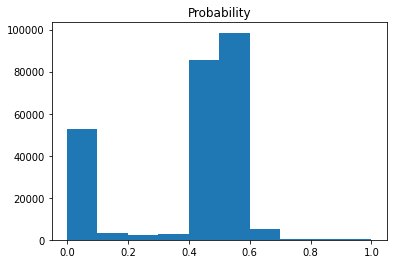

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots

fig1, ax1 = plt.subplots()
Plots.plot_hist(df.prob, ax=ax1, title='Probability')

In [60]:
cutoffs = np.linspace(0, 1, 10, endpoint=True)
cutoffs = (cutoffs * 10).astype(int) / 10

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1. ])